In [27]:
install.packages("pacman")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



#### Load package using pacman package

In [24]:
pacman::p_load(tidyquant,tidyverse,timetk,tibbletime,highcharter,glue,broom,ggplot2)

 we will explore the rolling Fama French model and the explanatory power of the 3 factors in different time periods. In the financial world, we often look at rolling means, standard deviations and models to make sure we haven’t missed anything unusual, risky, or concerning during different market or economic regimes. Our portfolio returns history is for the years 2013 through 2017, which is rather a short history, but there still might a be a 24-month period where the Fama French factors were particularly strong, weak, or meaningless. We would like to unearth and hypothesize about what explains them or their future likelihood.

The portfolio consists of :

In [4]:
set.seed(123)
symbols = c("SPY","EFA", "IJS", "EEM","AGG")


in the original post, w was consisted of specific values but I want to investigate rolling betas of fama french model following random weights, so I establisehd random weights named "w"

In [5]:
#random weights
w = length(symbols) %>%
  runif() %>%
  `/`(sum(.)) %>%
  round(.,digits = 3)


In [6]:
start = "2012-12-31" ; end = "2019-01-01"

We attempt to investigate 24 months betas, so I setted up rolling window size as 24

In [7]:
#rolling window size
window = 24

1. Download stock data using tq_get()
2. Bind data together using group_by()
3. Convert daily data into monthly data using tq_transmutate(). those data basically are based on "adjusted" data
4. All data are converted to log-return data using tq_transmutate(),
5. Calculate weighted portfolio returns using tq_portfolio()
6. the first row is 0, so we should eliminate the first row using slice()

In [8]:
portfolio = tq_get(
  symbols,
  from = start,
  to = end
) %>%
  group_by(symbol) %>%
  tq_transmute(
    select = adjusted,
    mutate_fun = to.monthly,
    indexAt = "lastof"
  ) %>%
  tq_transmute(
    select = adjusted,
    mutate_fun = periodReturn,
    type = "log"
  ) %>%
  tq_portfolio(
    assets_col = symbol,
    returns_col = monthly.returns,
    weights = w,
    col_rename = "returns",
    rebalance_on = "months"
  ) %>%
  slice(-1)

In [9]:
portfolio %>% head()

date,returns
<date>,<dbl>
2013-01-31,0.016966661
2013-02-28,-0.004473960
2013-03-31,0.008868116
2013-04-30,0.019425665
2013-05-31,-0.019013604
2013-06-30,-0.026896620


Download Fama-french 3 model via kennth french website.

(Actually, we can obtain this famafrench factor model using "frenchdata" package, but this package does not offer the monthly data so I downloaded this data using this code below)

In [11]:
temp = tempfile()
base =  "http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/"
factor = "Global_3_Factors"
format= "_CSV.zip"
full_url = glue(base,
       factor,
       format,
       sep ="")

download.file(
  full_url,
  temp,
  quiet = TRUE)
Global_3_Factors = read_csv(unz(temp, "Global_3_Factors.csv"),
           skip = 6) %>%
  rename(date = ...1) %>%
  mutate_at(vars(-date), as.numeric) %>%
  mutate(date =
           rollback(ymd(parse_date_time(date, "%Y%m") + months(1)))) %>%
  filter(date >= start & date <= end )


New names:
• `` -> `...1`
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 378 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): ...1, Mkt-RF, SMB, HML, RF

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There were 4 warnings in `mutate()`.
The first warning was:
ℹ In argument: `Mkt-RF = .Primitive("as.double")(`Mkt-RF`)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings.”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `date = rollback(ymd(parse_date_time(date, "%Y%m") +
  months(1)))`.
Caused by warning:
!  29 failed to parse.”


In [13]:
Global_3_Factors %>% head

date,Mkt-RF,SMB,HML,RF
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2012-12-31,2.30,1.19,3.55,0.01
2013-01-31,5.46,0.17,2.01,0.00
2013-02-28,0.09,0.35,-0.76,0.00
2013-03-31,2.29,0.85,-2.02,0.00
2013-04-30,3.02,-1.13,0.90,0.00
2013-05-31,0.56,-0.66,0.97,0.00


Bind "portfolio" and global 3 factors together

In [14]:
ff_portfolio_return = portfolio %>%
  left_join(.,Global_3_Factors,by = "date")

In [15]:
ff_portfolio_return %>% head

date,returns,Mkt-RF,SMB,HML,RF
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2013-01-31,0.016966661,5.46,0.17,2.01,0
2013-02-28,-0.004473960,0.09,0.35,-0.76,0
2013-03-31,0.008868116,2.29,0.85,-2.02,0
2013-04-30,0.019425665,3.02,-1.13,0.90,0
2013-05-31,-0.019013604,0.56,-0.66,0.97,0
2013-06-30,-0.026896620,-2.52,0.21,-0.06,0


We first define a rolling model with the rollify() function from tibbletime. However, instead of wrapping an existing function, such as kurtosis() or skewness(), we will pass in our linear Fama French model.

In [16]:
rolling_lm = rollify(.f = function(R_excess, MKT_RF, SMB, HML) {
    lm(R_excess ~ MKT_RF + SMB + HML)
  }, window = window, unlist = FALSE)

Next, we pass columns from ff_portfolio_returns to the rolling function model.



In [17]:
rolling_ff_beta = ff_portfolio_return %>%
  mutate(rolling_ff = rolling_lm(returns,`Mkt-RF`, SMB, HML)) %>%
  slice(-c(1:(window-1))) %>%
  select(date,rolling_ff)

We now have a new data frame called rolling_ff_betas, in which the column rolling_ff holds an S3 object of our model results. We can tidy() that column with map(rolling_ff, tidy) and then unnest() the results, very similar to our CAPM work, except we have more than one independent variable.

In [21]:
rolling_ff_beta = ff_portfolio_return %>%
  mutate(rolling_ff = rolling_lm(returns,`Mkt-RF`, SMB, HML)) %>%
  mutate(tidied = map(rolling_ff,tidy,conf.int = T)) %>%
  unnest(tidied) %>%
  slice(-c(1:23)) %>%
  select(date,term,estimate,conf.low,conf.high) %>%
  filter(term != "(Intercept)") %>%
  rename(beta = estimate, factor = term) %>%
  group_by(factor)


Warning message:
“There were 23 warnings in `mutate()`.
The first warning was:
ℹ In argument: `tidied = map(rolling_ff, tidy, conf.int = T)`.
Caused by warning:
! 'tidy.logical' is deprecated.
See help("Deprecated")
ℹ Run `dplyr::last_dplyr_warnings()` to see the 22 remaining warnings.”


In [22]:
rolling_ff_beta %>% head

date,factor,beta,conf.low,conf.high
<date>,<chr>,<dbl>,<dbl>,<dbl>
2014-12-31,MKT_RF,7.822357e-03,0.006075860,0.009568854
2014-12-31,SMB,-3.039636e-04,-0.003427899,0.002819972
2014-12-31,HML,-1.042627e-03,-0.004703887,0.002618633
2015-01-31,MKT_RF,8.126327e-03,0.006427301,0.009825352
2015-01-31,SMB,-7.124713e-05,-0.003036831,0.002894336
2015-01-31,HML,-7.193273e-04,-0.004150590,0.002711936


Visualize rolling betas

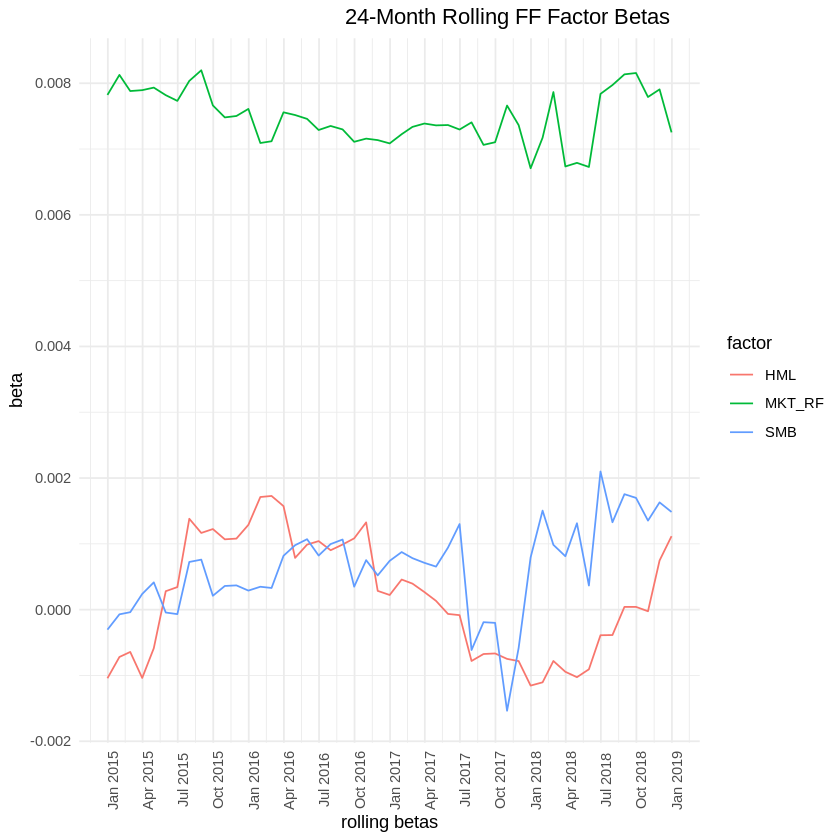

In [23]:
rolling_ff_beta %>%
  ggplot(aes(x = date,
             y = beta,
             color = factor)) +
  geom_line() +
  labs(title= "24-Month Rolling FF Factor Betas",
       x = "rolling betas") +
  scale_x_date(breaks = scales::pretty_breaks(n = 20)) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = .9),
        axis.text.x = element_text(angle = 90))

We now have rolling betas and confidence intervals for each of our 3 factors. Let’s apply the same code logic and extract the rolling R-squared for our model. The only difference is we call glance() instead of tidy().

In [25]:
rolling_ff_rsquared = ff_portfolio_return %>%
  mutate(rolling_ff = rolling_lm(returns,`Mkt-RF`, SMB, HML)) %>%
  slice(-c(1:23)) %>%
  mutate(glanced = map(rolling_ff,
                       glance)) %>%
  unnest(glanced) %>%
  select(date, r.squared, adj.r.squared, p.value)

head(rolling_ff_rsquared, 3)

date,r.squared,adj.r.squared,p.value
<date>,<dbl>,<dbl>,<dbl>
2014-12-31,0.8160097,0.7884111,1.501077e-07
2015-01-31,0.8344380,0.8096037,5.277024e-08
2015-02-28,0.8408798,0.8170117,3.560659e-08


Next, let’s visualize the rolling R-squared with highcharter.

We first convert rolling_ff_rsquared to xts, using the tk_xts() function.

In [26]:
rolling_ff_rsquared_xts = rolling_ff_rsquared %>%
  tk_xts(date_var = date, silent = TRUE)

highchart(type = "stock") %>%
  hc_add_series(rolling_ff_rsquared_xts$r.squared,
                color = "cornflowerblue",
                name = "r-squared") %>%
  hc_title(text = "Rolling FF 3-Factor R-Squared") %>%
  hc_add_theme(hc_theme_flat()) %>%
  hc_navigator(enabled = FALSE) %>%
  hc_scrollbar(enabled = FALSE) %>%
  hc_exporting(enabled = TRUE)

HTML widgets cannot be represented in plain text (need html)